In [1]:
import pandas as pd
df = pd.read_csv('../data/raw/medical_insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [3]:
df.duplicated().sum()

np.int64(1435)

In [4]:
df = df.drop_duplicates()

In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [7]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

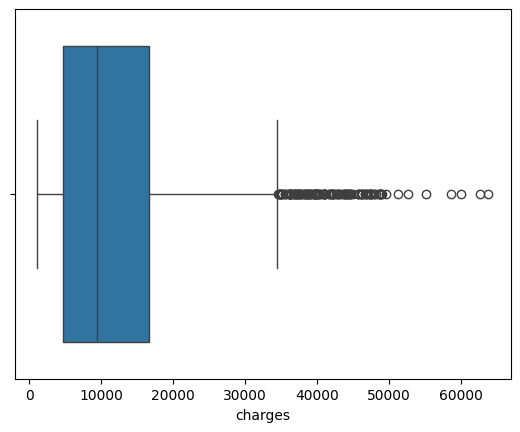

In [9]:
sns.boxplot(data=df, x='charges')
plt.show()

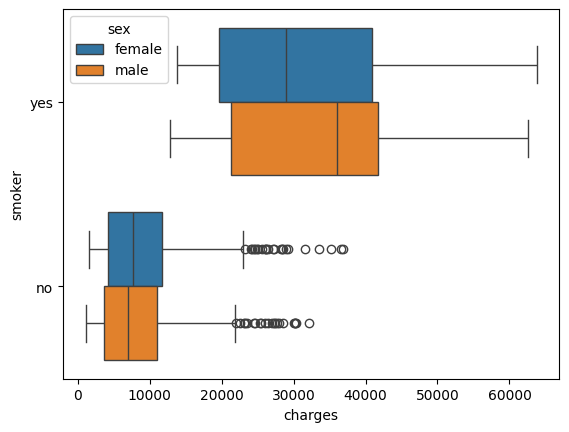

In [10]:
sns.boxplot(data=df, x='charges', y='smoker', hue='sex')
plt.show()

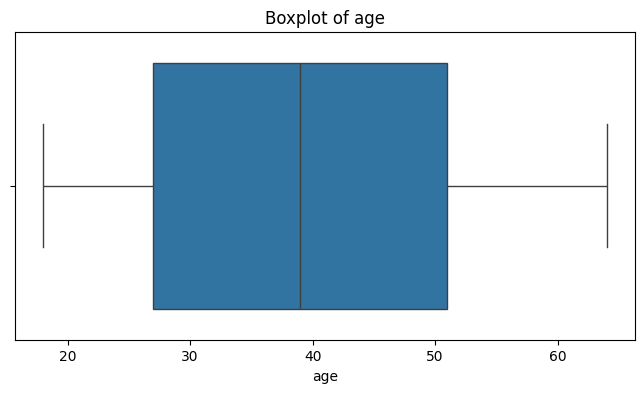

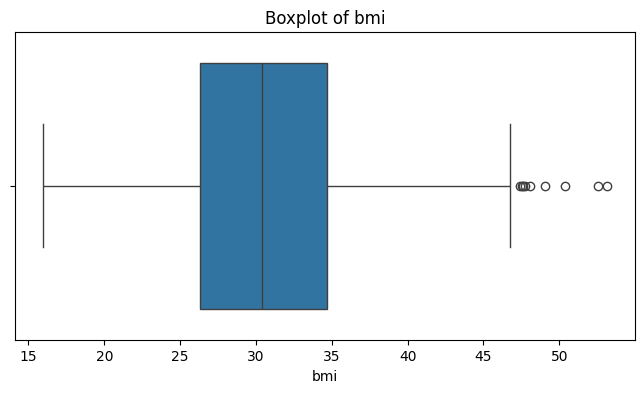

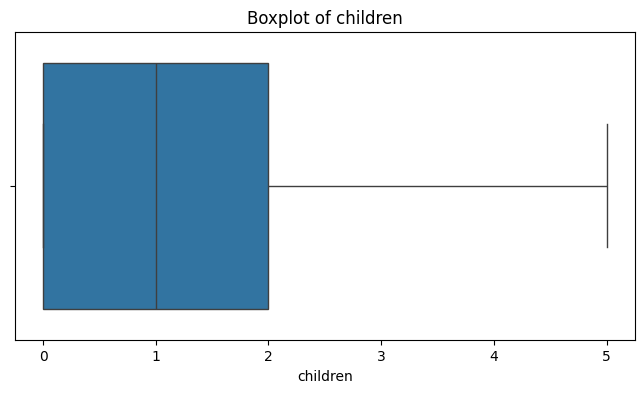

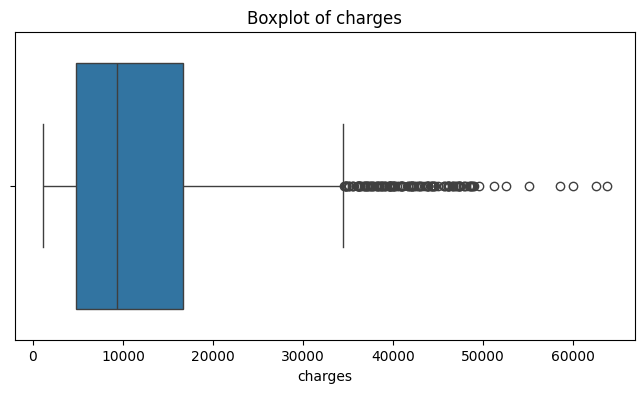

In [11]:
numeric_cols = df.select_dtypes(include=['number']).columns

for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df,x = df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [12]:
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print("Number of outliers: ", outliers.shape[0])   

Number of outliers:  0
Number of outliers:  9
Number of outliers:  0
Number of outliers:  139


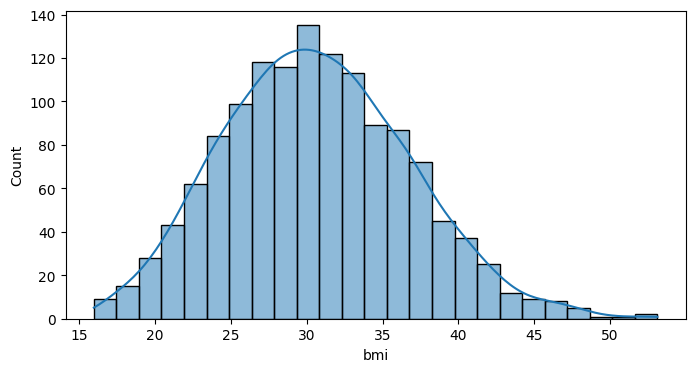

In [13]:
plt.figure(figsize=(8,4))
sns.histplot(df['bmi'], kde=True)
plt.show()

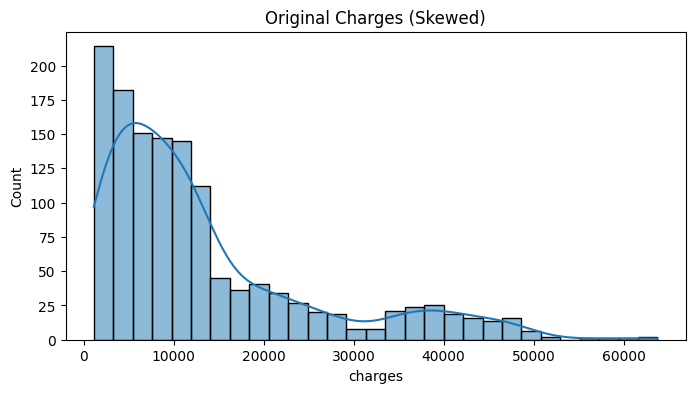

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))

sns.histplot(df['charges'], kde=True)
plt.title('Original Charges (Skewed)')
plt.show()

In [15]:
print(df['charges'].skew())

1.5153909108403483


In [16]:
import numpy as np

df['charges'] = np.log1p(df['charges'])

print("New skewness is ", df['charges'].skew())

New skewness is  -0.08955835073325419


In [17]:
X = df.drop(columns=['charges'])
y = df['charges']

In [18]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler , OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), ['age', 'bmi']),
        ('minmax', MinMaxScaler(), ['children']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['sex', 'smoker', 'region'])
    ]
)

In [19]:
from sklearn.linear_model import LinearRegression

lr_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('regressor',LinearRegression())
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_val_score(lr_pipeline,X,y,cv=kf,scoring='r2')

print(f"R2 Scores (5-Fold): {cv_results}")
print(f"Mean R2 Score: {cv_results.mean():.4f}")

R2 Scores (5-Fold): [0.82947863 0.72610588 0.74451437 0.74122219 0.77575437]
Mean R2 Score: 0.7634


In [20]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

cv_results_rf = cross_val_score(rf_pipeline, X, y, cv=kf, scoring='r2')

print(f"New Mean R2 Score: {cv_results_rf.mean():.4f}")
print(f"Individual Fold R2 Scores: {cv_results_rf}")

New Mean R2 Score: 0.8080
Individual Fold R2 Scores: [0.84935702 0.78336927 0.76473224 0.82131761 0.82108891]


In [21]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

xgb_model = XGBRegressor(
    n_estimators=100, 
    learning_rate=0.05, 
    max_depth=5, 
    random_state=42,
    objective='reg:squarederror'
)

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

cv_results_xgb = cross_val_score(xgb_pipeline, X, y, cv=kf, scoring='r2')

print(f"XGBoost Mean R2 Score: {cv_results_xgb.mean():.4f}")
print(f"XGBoost Individual Fold Scores: {cv_results_xgb}")

XGBoost Mean R2 Score: 0.8238
XGBoost Individual Fold Scores: [0.88190488 0.78500433 0.7926127  0.81945937 0.83985712]


In [22]:
import joblib

joblib.dump(lr_pipeline, '../models/insurance_linear_regression.pkl')

joblib.dump(rf_pipeline, '../models/insurance_random_forest.pkl')

joblib.dump(xgb_pipeline, '../models/insurance_xgboost_model.pkl')

['../models/insurance_xgboost_model.pkl']

In [23]:
import joblib

model_path = '../models/insurance_linear_regression.pkl'
loaded_model = joblib.load(model_path)

print(f"Model successfully loaded from {model_path} and is ready for inference!")

Model successfully loaded from ../models/insurance_linear_regression.pkl and is ready for inference!


In [24]:
df.to_csv('../data/processed/medical_insurance_cleaned.csv', index=False)

In [25]:
from sklearn.model_selection import train_test_split
import joblib

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_pipeline.fit(X_train, y_train)

joblib.dump(xgb_pipeline, '../models/insurance_xgboost_model.pkl')

test_prediction = xgb_pipeline.predict(X_test.iloc[[0]])
print(f"Test prediction: {test_prediction[0]}")

Test prediction: 9.170722961425781
